Vamos a comparar los distintos modelos predictivos de series temporales para análisis univariable.

### 1. Import libraries and files

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import quandl
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [3]:
quandl.ApiConfig.api_key = 'XXXXXXXXXXXXXX'
pricesAppl = quandl.get("WIKI/AAPL", start_date="1990-01-01", end_date="2017-12-31")

In [4]:
pricesAppl.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
1990-01-02,35.25,37.50,35.00,37.25,1635700.0,0.0,1.0,1.058061,1.125597,1.050557,1.118093,45799600.0
1990-01-03,38.00,38.00,37.50,37.50,1857100.0,0.0,1.0,1.140605,1.140605,1.125597,1.125597,51998800.0
1990-01-04,38.25,38.75,37.25,37.63,1977800.0,0.0,1.0,1.148109,1.163117,1.118093,1.129499,55378400.0
1990-01-05,37.75,38.25,37.00,37.75,1101000.0,0.0,1.0,1.133101,1.148109,1.110589,1.133101,30828000.0
1990-01-08,37.50,38.00,37.00,38.00,906900.0,0.0,1.0,1.125597,1.140605,1.110589,1.140605,25393200.0


In [6]:
pricesAppl.shape

(7054, 12)

In [7]:
pricesAppl.index

DatetimeIndex(['1990-01-02', '1990-01-03', '1990-01-04', '1990-01-05',
               '1990-01-08', '1990-01-09', '1990-01-10', '1990-01-11',
               '1990-01-12', '1990-01-15',
               ...
               '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20',
               '2017-12-21', '2017-12-22', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', name='Date', length=7054, freq=None)

### Naive approach

In [18]:
#Split into training and testing set
train = pricesAppl.loc[pricesAppl.index < '2017-01-01']
test = pricesAppl.loc[pricesAppl.index > '2016-12-31']

In [35]:
#Naive forecast
dd = np.asarray(train['Adj. Close'])
y_hat = test.copy()
y_hat['naive'] = dd[len(dd) - 1]

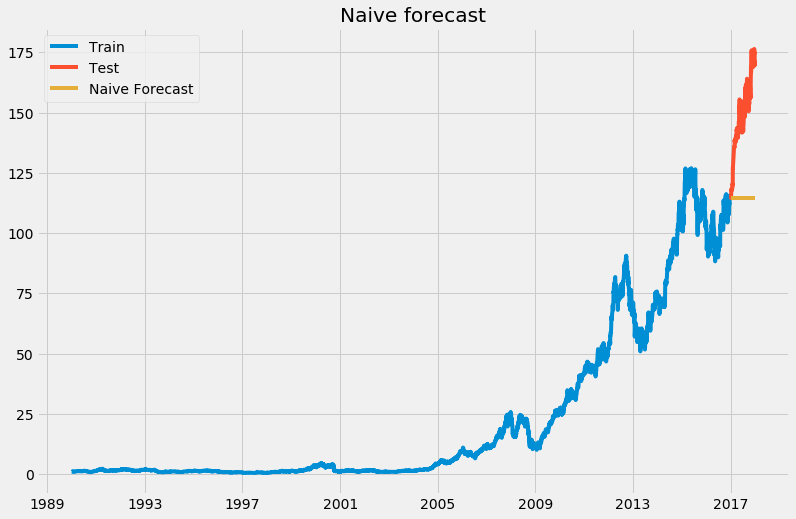

In [36]:
#Plot
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Adj. Close'], label='Train')
plt.plot(test.index, test['Adj. Close'], label='Test')
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title('Naive forecast')
plt.show()

 ##### Mean squared error

In [39]:
rms = sqrt(mean_squared_error(test['Adj. Close'], y_hat.naive))
print(rms)    

38.484841742265864


### Simple average

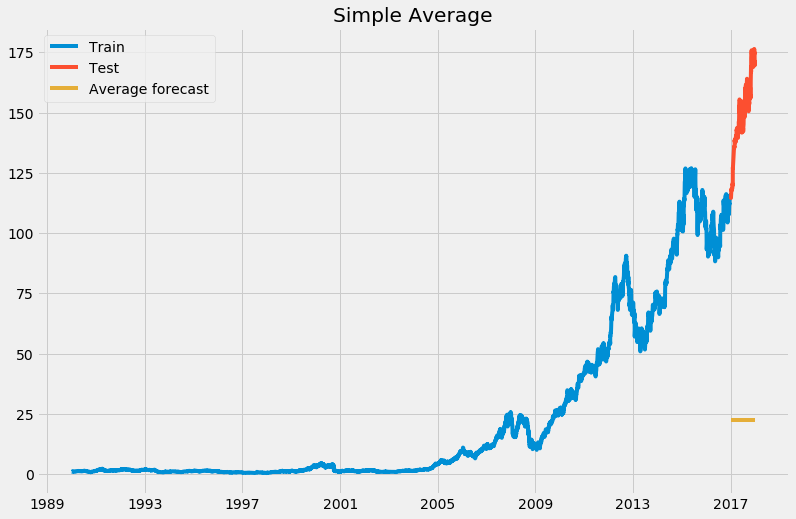

In [40]:
#Compute average
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Adj. Close'].mean()

#Plot
plt.figure(figsize=(12,8))
plt.plot(train['Adj. Close'], label='Train')
plt.plot(test['Adj. Close'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average forecast')
plt.legend(loc='best')
plt.title('Simple Average')       
plt.show()

In [41]:
#error computation
rms = sqrt(mean_squared_error(test['Adj. Close'], y_hat_avg.avg_forecast))
print(rms)

128.10804510874027


Para nuestro caso particular, el error producido por la media de valores es mayor que el de la aproximación 'Naive'. Vamos a darle más importancia a los valores más próximos en el tiempo, con 'moving average', que considera un parámetro p como el número de valores anteriores a considerar para calcular la media.

### Moving average

In [45]:
p = 365 #Nos quedamos con la media del último año
train2016 = train.loc[train.index > '2016-01-01']

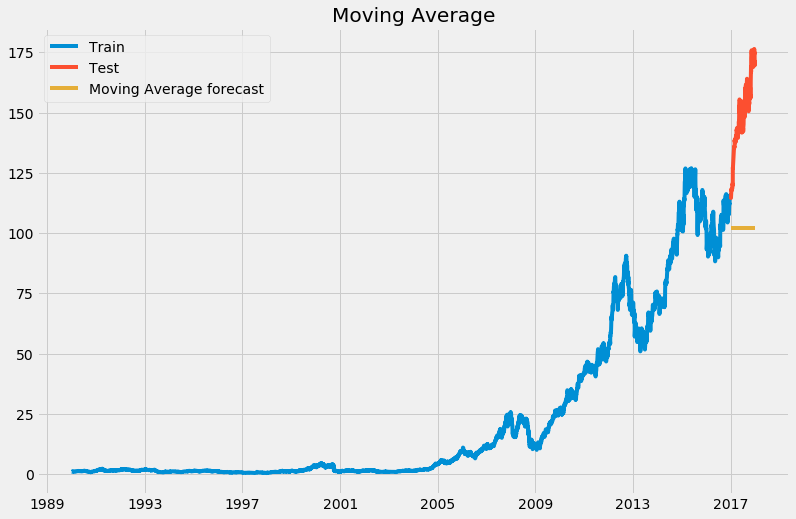

In [46]:
#Compute average
y_hat_mvn_avg = test.copy()
y_hat_mvn_avg['moving_avg_forecast'] = train2016['Adj. Close'].mean()

#Plot
plt.figure(figsize=(12,8))
plt.plot(train['Adj. Close'], label='Train')
plt.plot(test['Adj. Close'], label='Test')
plt.plot(y_hat_mvn_avg['moving_avg_forecast'], label='Moving Average forecast')
plt.legend(loc='best')
plt.title('Moving Average')       
plt.show()

In [47]:
#error computation
rms = sqrt(mean_squared_error(test['Adj. Close'], y_hat_mvn_avg.moving_avg_forecast))
print(rms)

49.82378640864596


Mejoramos el error pero sigue siendo peor que en la aproximación 'Naive'. Ahora vamos a intentar una aproximación en la que se da un peso a los distintos momentos en el tiempo.

### ARIMA

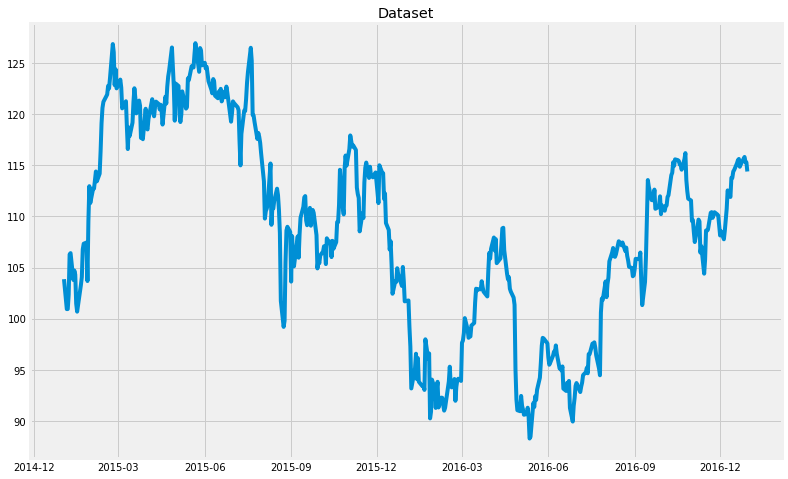

In [5]:
#Tarda demasiado, así que me voy a quedar con los datos de los años 2015-2016 para predecir 2017
pricesApplMin = pricesAppl.loc[(pricesAppl.index > '2015-01-01') & (pricesAppl.index < '2016-12-31')]
#Dibujamos el gráfico con el tiempo en el eje de las X y el valor del Adj. Close en el de las y's, para intentar observar
#si la serie temporal es estacionaria o no. Así a priori no se ve claro, por lo que habrá que investigar más a fondo.
plt.figure(figsize=(12,8))
plt.plot(pricesApplMin['Adj. Close'])
plt.title('Dataset')       
plt.show()

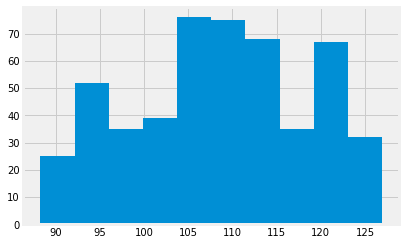

In [13]:
#Stationary Time Series: Las observaciones no dependen del tiempo. Además no se observan tendencias ni efectos estacionales.
#Los estadísticos (como la media o la varianza) son consistentes en el tiempo, con lo que es sencillo modelar la serie
#temporal. Es por esto que si nos encontramos con una Non-stationary time serie debamos convertirla en estacionaria (mediante
#la aplicación de diferencias) para poder modelarla.
#En este caso no tengo claro que la serie temporal sea estacionaria. Vamos a ver un histograma de las observaciones.
pricesApplMin['Adj. Close'].hist()
plt.show()

In [14]:
#Mmmmm... no tengo claro si sigue una distribución gaussiana. Hacemos un truco, que es dividir en dos partes las observaciones
#y calcular al media y la varianza. Si son muy distintas es no estacionaria
X = pricesApplMin['Adj. Close'].values
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=115.029737, mean2=102.314697
variance1=50.759098, variance2=62.688451


Sigo sin tenerlo claro. Voy a realizar un test estadístico. Para este caso el más usado es el de Augmented Dickey-Fuller test.
 * H0 (hipótiesis nula): la serie es no-estacionaria.
 * H1 (hipótesis alternativa): La seire es estacionaria.

- Tenemos que si p>0.05 no podemos rechazar la hipótesis nula con lo que podemos concluir que nuestra serie es no-estacionaria
- Si p<=0.05 debemos rechazar la hipótesis nula y nuestra serie es por tanto estacionaria.

In [15]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.904796
p-value: 0.329808
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


Como p-value > 0.05 podemos concluir que la serie es no-estacionaria, por lo que deberemos aplicar una diferenciación de al menos 1 (parámetro d=1 para el ARIMA)

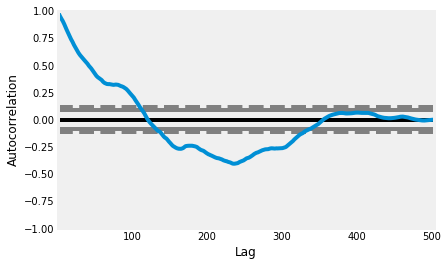

In [16]:
#Realizamos también el gráfico de autocorrelación
autocorrelation_plot(pricesApplMin['Adj. Close'])
plt.show()

Podemos observar que existe una correlación elevada para valores pequeños... vamos a probar en un pto de partida de 10 para el valor del parámetro AR (p).
Vamos a empezar con algo sencillo. Vamos a ajustar un modelo ARIMA con el dataset entero y revisar los errores residuales.

                             ARIMA Model Results                              
Dep. Variable:           D.Adj. Close   No. Observations:                  503
Model:                ARIMA(10, 1, 0)   Log Likelihood                -971.761
Method:                       css-mle   S.D. of innovations              1.670
Date:                Tue, 11 Dec 2018   AIC                           1967.521
Time:                        22:43:38   BIC                           2018.168
Sample:                    01-05-2015   HQIC                          1987.390
                         - 12-30-2016                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0208      0.077      0.270      0.787      -0.130       0.172
ar.L1.D.Adj. Close      0.0133      0.045      0.298      0.766      -0.074       0.101
ar.L2.D.Adj. Clo

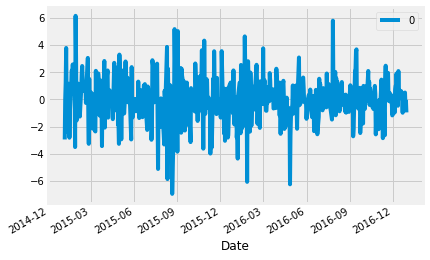

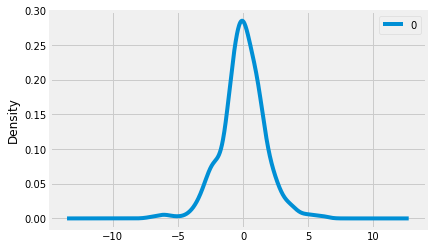

                0
count  503.000000
mean     0.000092
std      1.672047
min     -6.953947
25%     -0.826772
50%      0.032685
75%      0.998101
max      6.162424


In [22]:
# fit model
model = ARIMA(pricesApplMin['Adj. Close'], order=(10,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

#### Rolling Forecast ARIMA Model

Para hacer predicciones usaré los datos de 2015-2016 para train y haré predicciones sobre 2017. Para poder hacer predicciones en un modelo ARIMA necesitamos incorporar las nuevas observaciones al modelo, y será necesario ajustarlo en cada paso. Es decir, primero uso el modelo entrenado sobre 2015-2016 para predecir el primer valor de 2017. Luego incorpor el valor de 2017, se vuelve a ajustar el modelo y se predice el segundo valor y así sucesivamente.

predicted=114.424404, expected=114.715378
predicted=114.785855, expected=114.586983
predicted=114.627177, expected=115.169696
predicted=115.244756, expected=116.453639
predicted=116.439622, expected=117.520300
predicted=117.510842, expected=117.638817
predicted=117.442079, expected=118.270913
predicted=118.216472, expected=117.777088
predicted=117.644951, expected=117.569682
predicted=117.673355, expected=118.517825
predicted=118.649744, expected=118.507948
predicted=118.649814, expected=118.300542
predicted=118.421159, expected=118.517825
predicted=118.616065, expected=118.596837
predicted=118.594865, expected=118.488195
predicted=118.540727, expected=120.374604
predicted=120.452110, expected=120.433863
predicted=120.357494, expected=120.443739
predicted=120.480152, expected=120.127692
predicted=120.059164, expected=119.851150
predicted=119.887813, expected=127.159749
predicted=127.346053, expected=126.942467
predicted=126.720324, expected=127.485673
predicted=127.395814, expected=128

predicted=155.916962, expected=156.990000
predicted=157.261196, expected=159.880000
predicted=159.852287, expected=160.470000
predicted=160.560016, expected=159.760000
predicted=159.678609, expected=155.980000
predicted=156.121745, expected=156.160000
predicted=156.470202, expected=156.170000
predicted=156.464972, expected=157.100000
predicted=157.331626, expected=156.405000
predicted=156.503385, expected=157.410000
predicted=157.684241, expected=163.050000
predicted=162.916783, expected=166.720000
predicted=166.459895, expected=169.040000
predicted=168.476077, expected=166.890000
predicted=166.751722, expected=168.110000
predicted=168.268671, expected=172.500000
predicted=172.864525, expected=174.250000
predicted=174.373948, expected=174.810000
predicted=174.929870, expected=175.880000
predicted=176.655061, expected=174.670000
predicted=174.871069, expected=173.970000
predicted=174.297672, expected=171.340000
predicted=171.463982, expected=169.080000
predicted=169.488053, expected=171

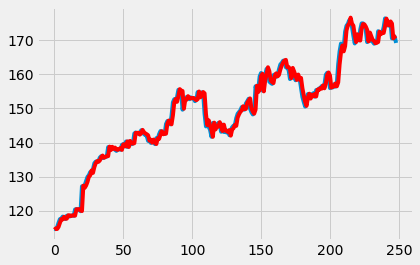

In [35]:
dtTrain = pricesAppl.loc[(pricesAppl.index > '2015-01-01') & (pricesAppl.index < '2016-12-31')]
train = dtTrain['Adj. Close'].values
dtTest = pricesAppl.loc[(pricesAppl.index > '2017-01-01')] 
test = dtTest['Adj. Close'].values
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(10,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

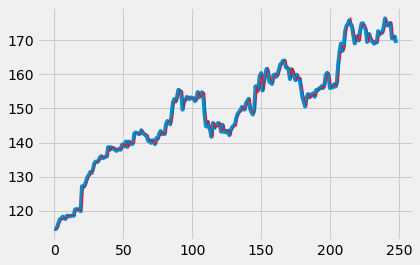

In [42]:
plt.plot(test)
plt.plot(predictions, color='red', linewidth=0.8)
plt.show()

In [39]:
#error computation
rms = sqrt(mean_squared_error(test, predictions))
print('Root MSE: ', rms)

Root MSE:  1.6988691687997504


Como se puede observar tanto con el gráfico como por el error hemos mejorado mucho las predicciones anteriores.

### Simple Exponential Smoothing

In [51]:
from statsmodels.tsa.api import ExponentialSmoothing


ImportError: cannot import name 'ExponentialSmoothing'